In [40]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [41]:
import pandas as pd
import numpy as np


### Loading smart campaign alphas

In [42]:
from smartcampaign import SmartCampaignSimplified
from smartcampaign.tools import risk_atr

## Creating customized SmartCampaign

In [43]:
class SmartCampaignPlainWeights(SmartCampaignSimplified):    
    def compose_portfolio(self, df_alpha_equity, equity_last=0, **portfolio_context) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)

        You should place all portfolio management and reinvestment logic here, unlike the SmartCampaignBase the simplified
        version uses very straightforward logic in sake of clarity and flexibility. End developer must define all alpha logic and
        reinvestment here.

        :param df_alpha_equity: Individual alphas series (weighted by static weights from campaign context), stacked alphas are merged
        :param equity_last: last value of equity (for money management purposes)
        :param **portfolio_context: PORTFOLIO_CONTEXT parameter dictionary from .backtest() method
        :return: dict[alpha_name: adj_alpha_size]
        """
        
        w = portfolio_context['initial_weight']
                
        return {alpha_name: w for alpha_name in df_alpha_equity}
    
    
    
class SmartCampaignInvVol(SmartCampaignSimplified):    
    def compose_portfolio(self, df_alpha_equity, equity_last=0, **portfolio_context) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)

        You should place all portfolio management and reinvestment logic here, unlike the SmartCampaignBase the simplified
        version uses very straightforward logic in sake of clarity and flexibility. End developer must define all alpha logic and
        reinvestment here.

        :param df_alpha_equity: Individual alphas series (weighted by static weights from campaign context), stacked alphas are merged
        :param equity_last: last value of equity (for money management purposes)
        :param **portfolio_context: PORTFOLIO_CONTEXT parameter dictionary from .backtest() method
        :return: dict[alpha_name: adj_alpha_size]
        """
        
        # Based on bt InvVol method
        # http://pmorissette.github.io/bt/_modules/bt/algos.html#WeighInvVol
        
        # it uses ffn.calc_inv_vol_weights under the hood
        # http://pmorissette.github.io/ffn/_modules/ffn/core.html#calc_inv_vol_weights
        
        # IMPORTANT: since calc_inv_vol_weights is working with % return and TMQR alphas are in USD 
        #   we have to mimic the method but not replicate, lets use ATR
        w = portfolio_context['initial_weight']
        
        inv_risk = 1/df_alpha_equity.apply(lambda x: risk_atr(x, 60))
        
        risk_inv_w = inv_risk.div(inv_risk.sum(axis=1), axis=0)
        
        # Clean NaN and return last weights                
        return (risk_inv_w.iloc[-1] * w).fillna(0.0).to_dict()
    
    
class SmartCampaignTargetWeights(SmartCampaignSimplified):    
    def compose_portfolio(self, df_alpha_equity, equity_last=0, **portfolio_context) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)

        You should place all portfolio management and reinvestment logic here, unlike the SmartCampaignBase the simplified
        version uses very straightforward logic in sake of clarity and flexibility. End developer must define all alpha logic and
        reinvestment here.

        :param df_alpha_equity: Individual alphas series (weighted by static weights from campaign context), stacked alphas are merged
        :param equity_last: last value of equity (for money management purposes)
        :param **portfolio_context: PORTFOLIO_CONTEXT parameter dictionary from .backtest() method
        :return: dict[alpha_name: adj_alpha_size]
        """
        #
        # Target weights algo        
        # 1. Aggregate total equity from all alphas
        # 2. Calculate simple statistic (median)
        # 3. Apply adjusted weight to all alphas
        
        w = portfolio_context['initial_weight']
        
        total = df_alpha_equity.diff().sum(axis=1).cumsum()
        
        meadian_eq = total.rolling(210).median()
        
        tw = pd.Series(0, index=total.index)
        tw[total > meadian_eq] = 2.00
        tw[total <= meadian_eq] = 1.00
                
        last_tw = tw[-1]
       
        return {alpha_name: w*last_tw for alpha_name in df_alpha_equity}
                        

# Backtesting

In [44]:
import os
def make_alphas_df(campaigns_dict):
    """
    This is a shortcut method for building campaings based on CSV data
    """
    def load_csv_alpha(alpha_name):        
        base_path = os.path.join('/home/tmqr/v1/notebooks/PAM Enhanced/', 'S&P Alphas')
        fn = os.path.join(base_path, alpha_name + '.csv')
        
        if alpha_name == 'SP':
            # SP.csv has different format (workaround this)
            df = pd.read_csv(fn, index_col=0, parse_dates=True, names=['date', 'equity'])
            assert 'equity' in df, 'Missing "equity" column in the file'
            df['costs'] = 0.0
            df['exposure'] = 0.0
            df['delta'] = 0.0
        else:
            df = pd.read_csv(fn, index_col=0, parse_dates=True)
            assert 'equity' in df, 'Missing "equity" column in the file'
            if 'costs' not in df:
                df['costs'] = 0.0
            if 'exposure' not in df:
                df['exposure'] = 0.0
            if 'delta' not in df:
                print("Missing delta series for {0}".format(alpha_name))
                df['delta'] = 0.0     
        
        return df
    
    result = {}    
    for alpha_name, alpha_val in campaigns_dict['alphas'].items():
        if isinstance(alpha_val, dict):
            # This is a composite alpha, load one by one
            for _inner_alpha in alpha_val['alphas'].keys():
                result[_inner_alpha] = load_csv_alpha(_inner_alpha)
        else:
            # This is a standalone alpha, load as is
            result[alpha_name] = load_csv_alpha(alpha_name)
            
    return result
                
                

In [45]:
#
# Init Smart Campaign
#
import datetime


start_date = datetime.datetime(2011, 1, 1)

# PORTFOLIO_CONTEXT - will contain specific settings available per account basis

PORTFOLIO_CONTEXT = {
    'initial_capital': 550000,
    'risk_free_rate': 0.00, # 0.02 = 2% annual rate
    # Initial campaign weight coefficient
    'initial_weight':1.0,   
    
}

CAMPAIGN_DICT = {
    'name': "SmartCampaignSimple_Concept",
    
    #
    # Campaign definition
    #
    'alphas': {    
#         # If alpha is single-legged the name must be a CSV file name without extension (case sensitive!)
#         'SP': 1.0,
#         'Strat_ML_Sar_VX_long_1': 1.0,
#         'Strat_ML_Sar_VX_long_2': 1.0,
#         'Strat_ML_Sar_VX_long_3': 1.0,
#         'Strat_ML_Sar_VX_long_4': 1.0,
#         'Strat_ML_Sar_VX_long_5': 1.0,
#         'Strat_ML_Sar_VX_long_6': 1.0,
        'vix_w_deltas': 2.0,
        'es_w_deltas': -5.0,
        
        
        'boll_long1_w_deltas': 2.0,
        'boll_short1_w_deltas':1.0,
        
        
#         ####the upper level name may be arbitrary for composite alphas 
        'alpha_composite_ml_1':
        {
            'alphas':{
#       #####Legs of the composite alphas must be a CSV file without extension (case sensitive!)
                'Strat_ML_long_1_w_deltas':3.0,

#                 'Strat_ML_long_2_w_deltas':2.0,

                'Strat_ML_long_3_w_deltas':3.0,
                'Strat_ML_long_4_w_deltas':3.0,
                'Strat_ML_long_5_w_deltas':3.0,
                'Strat_ML_Sar_long_1_w_deltas':3.0,
                
#                 'boll_short1':1.0,
                'Strat_ML_short_1_w_deltas':2.0,
                'Strat_ML_short_2_w_deltas':2.0,
                'Strat_ML_Sar_short_1_w_deltas':2.0,
                'Strat_ML_short_3_w_deltas':2.0,
#                 'Strat_ML_long_1':1.0
            
                
            }
            
            
            
            
        },
    }

}


#
# Backtest
#

# Read all CSV in CAMPAIGN_DICT and create all data required by the smart campaign
alphas_df = make_alphas_df(CAMPAIGN_DICT)
    
# scmp = SmartCampaignPlainWeights(CAMPAIGN_DICT, alphas_df)
# scmp = SmartCampaignInvVol(CAMPAIGN_DICT, alphas_df)
scmp = SmartCampaignTargetWeights(CAMPAIGN_DICT, alphas_df)

bt_dict = scmp.backtest(PORTFOLIO_CONTEXT, start_date)

Fallback mode: simple v1 campaigns with fixed initial weights, however you still must to handle these weights manually in compose_portfolio() function
Last equity date: 2019-03-07 00:00:00


CAMPAIGN STATS                               
--------------
Start Date                         2011-06-01
End Date                           2019-03-07
Risk Free Rate                          0.00%

NetProfit $                         548443.50
NetProfit %                            99.72%
MaxDD $                            -189817.50
MaxDD %                               -29.42%
AverageDD $                         -74690.14
AverageDD %                           -11.39%
CAGR %                                  9.31%
Daily Sharpe                             0.04
Daily Sortino                            0.04
Calmar Ratio                             0.32

HISTORICAL PERFORMANCE
----------------------
30 days                                 0.87%
3 months                               34.46%
6 months                               48.04%
YTD                                     0.11%
1 year                                 32.20%
3 years (ann.)                         31.26%
5 years (ann.)   

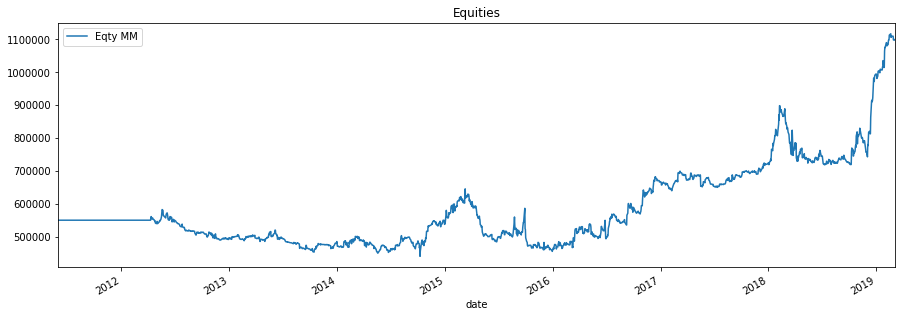

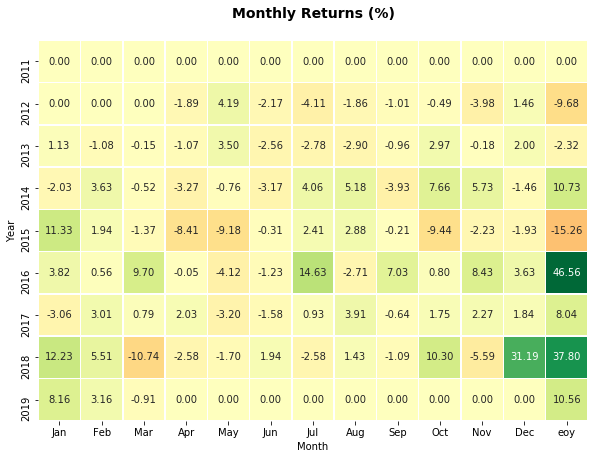

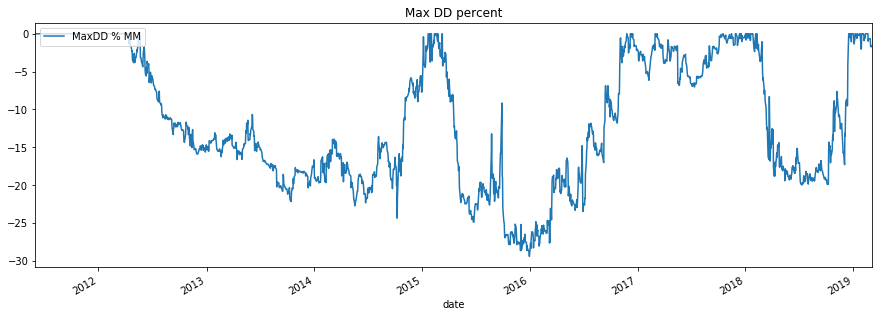

<Figure size 1080x360 with 0 Axes>

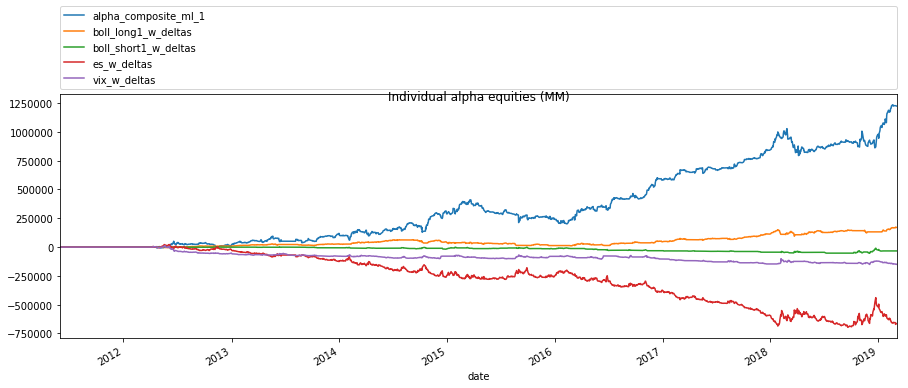

<Figure size 1080x360 with 0 Axes>

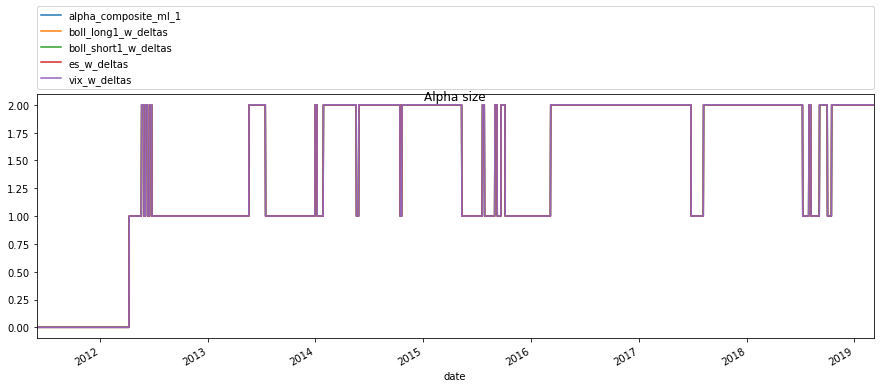

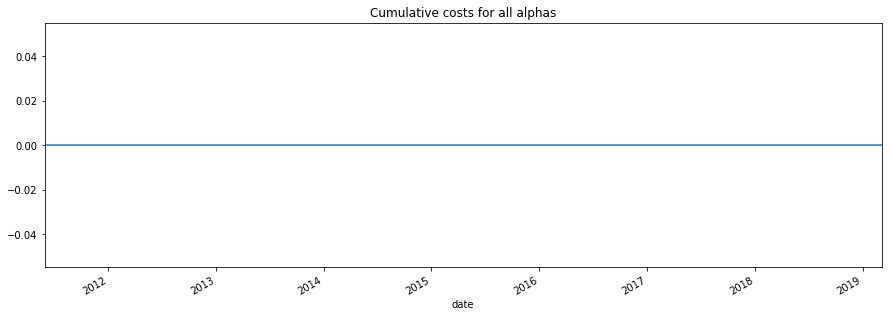

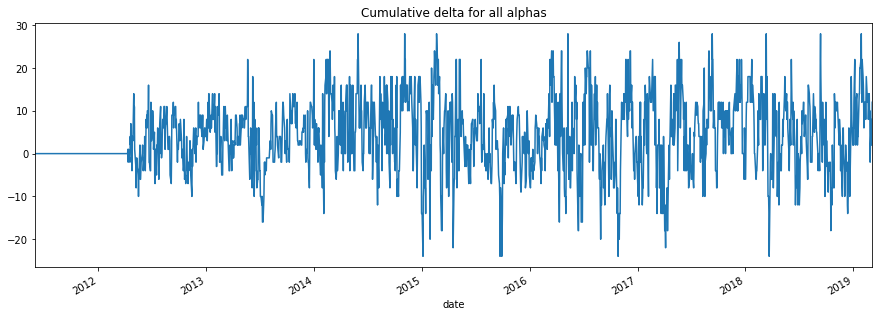

In [46]:
figsize(15, 5)
scmp.report(bt_dict)

In [47]:
bt_dict['equity_mm'].to_csv('short_leg.csv')

In [48]:
bt_dict['alphas_deltas_mm'].to_csv('short_leg_deltas.csv')